# Calculate Ocean Bottom Pressure Anomaly fields relative to their 2005-1020 mean

Ian Fenty, 

Created: 2025-04-23
Last modified: 2025-04-25

* Assumes OBP files are on a local disk ('/tmp/')
* Assumes dask scheduler and workers are running
* Works well with at 16 or 24 processors
* Requires ecco_v4_py package is installed


Notes: 
Checks file precision in the *meta files of the original obp files

1. start tmux
   
3. in one window:

   $ dask-scheduler
   
5. in another window:

   $ dask worker localhost:8786 --nthreads 1 --nworkers 24

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob

import matplotlib.pyplot as plt
import os
import time;
from pprint import pprint
from pathlib import Path

## Initalize Python libraries
from datetime import datetime
import requests
import shutil
import time as time
from os.path import basename, isfile, isdir, join, expanduser
import sys

#sys.path.append('/home/jpluser/git_repos/ECCOv4-py')
import ecco_v4_py as ecco
from xmitgcm import open_mdsdataset

# setting up a dask LocalCluster
import dask as dask
from dask.distributed import Client
from dask.distributed import LocalCluster


In [3]:
#from distributed import Client
client = Client('127.0.0.1:8786')
client.restart()


# should be 1 thread per worker
nthreads=len(client.nthreads())
print('# of threads: ', nthreads)


# of threads:  24


In [41]:
def make_filename(new_prefix, timestep):
    filename = new_prefix + '.' + str(np.char.zfill(str(timestep),10)) + '.data'
    return filename

In [184]:
# grid directory

mds_grid_dir = '/home/jpluser/efs-mount-point/ifenty/granules/mds_grid_dir/'

# For V4r5
model_start_datetime = np.datetime64('1992-01-01T12:00:00'),
delta_t=3600




# Different Fields/Time Levels to Process

In [149]:
# Run this notebook 6X, one for each of these 'proc_fields'

proc_field='OBP_mon_mean'
proc_field='OBP_day_mean'
proc_field='OBP_day_snap'

proc_field='OBPGMAP_mon_mean'
proc_field='OBPGMAP_day_mean'
proc_field='OBPGMAP_day_snap'

In [150]:
print(proc_field)


match proc_field:
    ## Monthly mean OBP --> OBPAnoma_mon_mean   
    case 'OBP_mon_mean':
        freq = 'mon_mean'
        old_varname = 'OBP'
        new_varname = 'OBPAnoma'   
    
    ## Daily mean OBP --> OBPAnoma_day_mean   
    case 'OBP_day_mean':
        freq = 'day_mean'
        old_varname = 'OBP'
        new_varname = 'OBPAnoma'   

    ## Snapshots OBP --> OBPAnoma_day_snap
    case 'OBP_day_snap': 
        freq = 'day_snap'
        old_varname = 'OBP'
        new_varname = 'OBPAnoma'   
        
    ## Monthly mean OBPGMAP --> OBPGMAPA_mon_mean   
    case 'OBPGMAP_mon_mean':
        freq = 'mon_mean'
        old_varname = 'OBPGMAP'
        new_varname = 'OBPGMAPA'

    ## Daily mean OBPGMAP --> OBPGMAPA_day_mean   
    case 'OBPGMAP_day_mean':
        freq = 'day_mean'
        old_varname = 'OBPGMAP'
        new_varname = 'OBPGMAPA'

    ## Snapshots OBP --> OBPAnoma_day_snap
    case 'OBPGMAP_day_snap': 
        freq = 'day_snap'
        old_varname = 'OBPGMAP'
        new_varname = 'OBPGMAPA'   


OBPGMAP_day_snap


## Create Paths Etc

In [151]:
old_mds_var_dir = '/tmp/' + old_varname + '_' + freq

new_mds_var_dir     = Path('/tmp/' + new_varname + '_' + freq)
new_mds_var_ref_dir = Path('/tmp/' + new_varname + '_' + freq + '_reference')

new_mds_var_dir.mkdir(exist_ok=True)
new_mds_var_ref_dir.mkdir(exist_ok=True)

old_prefix=  old_varname + '_' + freq
new_prefix = new_varname + '_' + freq

In [152]:
if freq == 'mon_mean':
    ofc='AVG_MON'
elif freq == 'day_mean':
    ofc='AVG_DAY'
elif freq == 'day_snap':
    ofc='SNAP'


In [153]:
print(old_varname, old_prefix)
print(new_varname, new_prefix)
print(old_mds_var_dir)
print(new_mds_var_dir)

OBPGMAP OBPGMAP_day_snap
OBPGMAPA OBPGMAPA_day_snap
/tmp/OBPGMAP_day_snap
/tmp/OBPGMAPA_day_snap


In [154]:
mds_files = np.sort(list(Path(old_mds_var_dir).glob('*data')))
mds_files = [str(mds_file).split('/')[-1] for mds_file in mds_files]
mds_files[:5]


['OBPGMAP_day_snap.0000000012.data',
 'OBPGMAP_day_snap.0000000036.data',
 'OBPGMAP_day_snap.0000000060.data',
 'OBPGMAP_day_snap.0000000084.data',
 'OBPGMAP_day_snap.0000000108.data']

## Determine the precision of the original mds files by examining the first 'meta' file

In [155]:
mds_meta_files = np.sort(list(Path(old_mds_var_dir).glob('*meta')))
print('first two meta files')
print(mds_meta_files[:2])

with open(mds_meta_files[0], 'r') as f:
    lines = f.readlines()

# Find the line containing 'dataprec'
for line in lines:
    if 'dataprec' in line:
        dataprec_line = line
        break

# Now dataprec_line contains the line with 'dataprec'
print('\nparsed dataprec_lin ', dataprec_line)
if 'float64' in dataprec_line:
    file_dtype = '>f8'
if 'float32' in dataprec_line:
    file_dtype = '>f4'

print('file data type:', file_dtype)

first two meta files
[PosixPath('/tmp/OBPGMAP_day_snap/OBPGMAP_day_snap.0000000012.meta')
 PosixPath('/tmp/OBPGMAP_day_snap/OBPGMAP_day_snap.0000000036.meta')]

parsed dataprec_lin   dataprec = [ 'float32' ];

file data type: >f4


In [156]:
all_time_steps = ecco.get_time_steps_from_mds_files(old_mds_var_dir, old_prefix, less_output=True)
all_time_steps[0]
print(len(all_time_steps))

get time steps
10226


In [157]:
#model_time_steps_to_load=[732, 1428]
model_time_steps_to_load=all_time_steps #[:500] #[0:2000]
#model_time_steps_to_load='all'

In [158]:
# split the list of all time steps in nsplits groups
# one group per nthread/worker
nsplits=nthreads

all_time_steps_split = np.array_split(all_time_steps, nsplits)
print(len(all_time_steps_split))

24


In [159]:
client.restart()

In [160]:
# use Dask delayed to lazy-load the mds files 
# spread the lazy-loading into nclients

# spreading the lazy-loading across multiple 
# workers is *much* faster than using one process

# During the lazy-load not much is shown in the dask dashboard
# the long delay could mostly be in building the dask compute graph.  

@dask.delayed
def load_ecco_vars(model_time_steps_to_load):

    # these parameters should make the load pretty fast

    tmp = ecco.load_ecco_vars_from_mds(old_mds_var_dir,
                    mds_grid_dir = mds_grid_dir,
                    mds_files    = old_prefix,
                    vars_to_load = old_varname,
                    model_time_steps_to_load = model_time_steps_to_load,
                    model_start_datetime = model_start_datetime,
                    delta_t = delta_t,
                    output_freq_code = ofc,
                    drop_unused_coords = False,
                    grid_vars_to_coords = False,
                    coordinate_metadata = [],
                    variable_metadata = [],
                    global_metadata = [],
                    cell_bounds = None,
                    llc_method = 'smallchunks',
                    less_output=True,
                    read_grid=False)
    return tmp
    

In [161]:
# build the delayed array
st = time.time()
result =[]

# loop through each model time step group (there are nsplits of them)
for i in range(nsplits):
    # figure out which time steps this process is lazy-loading
    model_time_steps_to_load = list(all_time_steps_split[i])

    # append the dask delayed load_ecco_vars to the result list
    result.append(load_ecco_vars(model_time_steps_to_load))

end_time = time.time()

# execute / compute / lazy-load
start_time = time.time()

tmp = dask.compute(result)[0]

et = time.time()

print('total time ', et-st)
print('time per record ', (et-st)/len(all_time_steps))

# loading should be about 0.002 seconds per time step
ecco_dataset = xr.concat(tmp, dim='time')

# 2e-3 x 10e4  = 2e1 seconds (for 10k files, 30 seconds is normal)


total time  26.337156295776367
time per record  0.0025755091233890443


In [162]:
print(ecco_dataset.data_vars)
print('ntime ' , len(ecco_dataset.time))

Data variables:
    OBPGMAP  (time, tile, j, i) float32 4GB dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
ntime  10226


In [163]:
A = ecco_dataset[old_varname][0].load()
B = ecco_dataset[old_varname][100].load()
print('num non finite: A', np.sum(~np.isfinite(A.values)))
print('num non finite: B', np.sum(~np.isfinite(B.values)))

num non finite: A 0
num non finite: B 0


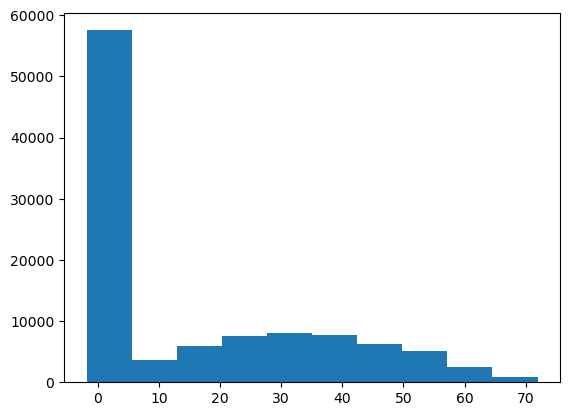

In [164]:
plt.hist(np.ravel(B.values[:]));

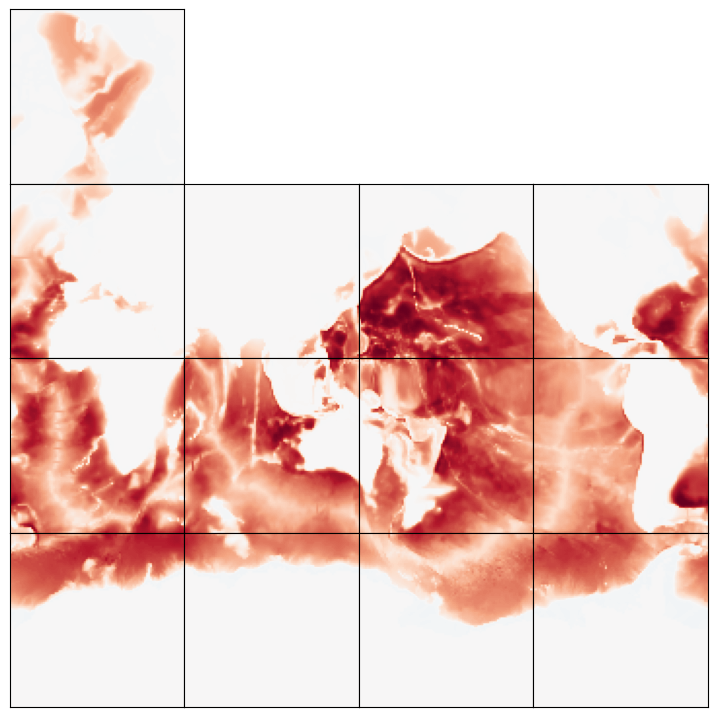

In [165]:
ecco.plot_tiles(A, rotate_to_latlon='true', layout='latlon', show_tile_labels=False);

## Load the timestep list

In [166]:
ecco_dataset.timestep.load()
ecco_dataset.timestep[:10]

<xarray.DataArray 'timestep' (time: 10)> Size: 80B
array([ 12,  36,  60,  84, 108, 132, 156, 180, 204, 228])
Coordinates:
    timestep  (time) int64 80B 12 36 60 84 108 132 156 180 204 228
  * time      (time) datetime64[ns] 80B 1992-01-02 1992-01-03 ... 1992-01-11
Attributes:
    long_name:  model timestep number

# Calculate the 2005-2010 mean

In [167]:
# name of 2005-2010 reference file
ref_filename = new_mds_var_ref_dir / Path(str(old_prefix) + "_reference_2005-2010.nc")
print(ref_filename)

/tmp/OBPGMAPA_day_snap_reference/OBPGMAP_day_snap_reference_2005-2010.nc


In [168]:
ecco_var_all = ecco_dataset[old_varname]

In [169]:
ecco_var_2005_2010_slice = ecco_var_all.sel(time=slice("2005-01-01T00:00:00",
                                                       "2010-01-01T00:00:00"))
print('start and end time of slice')
print(ecco_var_2005_2010_slice.time[0].values,ecco_var_2005_2010_slice.time[-1].values)
print('nrecs = ', len(ecco_var_2005_2010_slice.time))

start and end time of slice
2005-01-01T00:00:00.000000000 2010-01-01T00:00:00.000000000
nrecs =  1827


In [170]:
ecco_var_all=ecco_var_all.chunk(chunks={"time":160, "tile":13})
ecco_var_all

<xarray.DataArray 'OBPGMAP' (time: 10226, tile: 13, j: 90, i: 90)> Size: 4GB
dask.array<rechunk-merge, shape=(10226, 13, 90, 90), dtype=float32, chunksize=(160, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
    timestep  (time) int64 82kB dask.array<chunksize=(160,), meta=np.ndarray>
  * i         (i) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j         (j) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile      (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time      (time) datetime64[ns] 82kB 1992-01-02 1992-01-03 ... 2019-12-31
Attributes:
    long_name:  Ocean Bottom Pressure Including Global Mean Atmospheric Pressure
    units:      m^2/s^2

### Compute the 2005-2010 time mean

In [171]:
start_time = time.time()

ecco_var_2005_2010_slice_mean = ecco_var_2005_2010_slice.mean(dim='time').compute()

print('total time ' , time.time()-start_time)

# Takes 60s for 10k fields, 
# Takes 2s  for 360 fields


total time  49.968544721603394


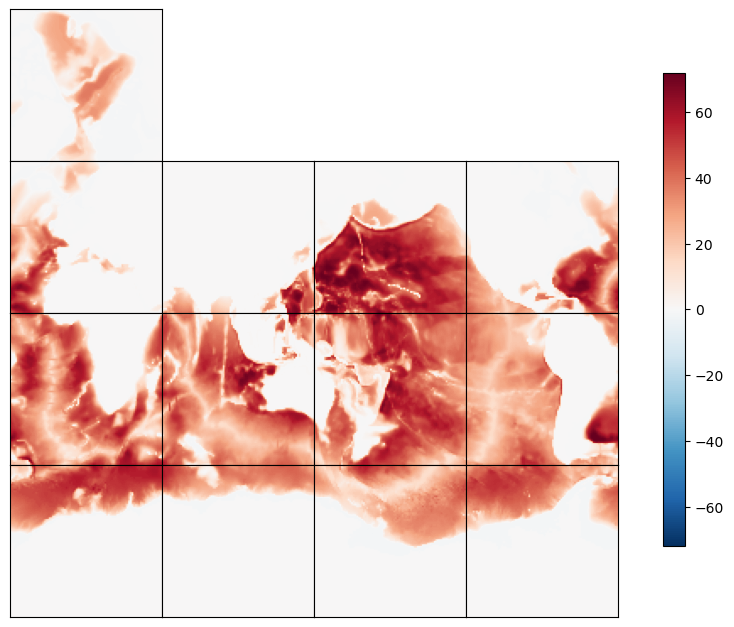

In [172]:
ecco.plot_tiles(ecco_var_2005_2010_slice_mean, show_colorbar=True, rotate_to_latlon='true', layout='latlon', show_tile_labels=False);

## save reference field to disk

In [173]:
print(old_varname)
print(ref_filename)
ecco_var_2005_2010_slice_mean.to_netcdf(ref_filename)

OBPGMAP
/tmp/OBPGMAPA_day_snap_reference/OBPGMAP_day_snap_reference_2005-2010.nc


# Test production of new filename

In [174]:
timestep=732
str(np.char.zfill(str(timestep),10))
new_filename = make_filename(new_prefix, 732)
print(new_filename)

timestep=732
str(np.char.zfill(str(timestep),10))
new_filename = make_filename(old_prefix, 732)
print(new_filename)

OBPGMAPA_day_snap.0000000732.data
OBPGMAP_day_snap.0000000732.data


# Remove 2005-2010 reference mean from all fields

In [175]:
ecco_var_all=ecco_var_all.chunk(chunks={"time":1, "tile":13})
ecco_var_all

<xarray.DataArray 'OBPGMAP' (time: 10226, tile: 13, j: 90, i: 90)> Size: 4GB
dask.array<rechunk-merge, shape=(10226, 13, 90, 90), dtype=float32, chunksize=(1, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
    timestep  (time) int64 82kB dask.array<chunksize=(1,), meta=np.ndarray>
  * i         (i) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j         (j) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile      (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time      (time) datetime64[ns] 82kB 1992-01-02 1992-01-03 ... 2019-12-31
Attributes:
    long_name:  Ocean Bottom Pressure Including Global Mean Atmospheric Pressure
    units:      m^2/s^2

In [176]:
@dask.delayed
def remove_anomaly(model_timestep, ref):

    # reference field and cur_OBP are 13x90x90 arrays
    #cur_OBP = ecco_var_all.sel(time=ecco_var_all.timestep==model_timestep).values
    
    old_filename = make_filename(old_prefix, model_timestep)
    print(old_filename)
      
    cur_OBP = ecco.read_llc_to_tiles(old_mds_var_dir, old_filename, filetype= file_dtype)
    print(np.shape(cur_OBP))
    
    OBP_anom = cur_OBP - ref

    new_filename = make_filename(new_prefix, model_timestep)
    print(new_filename)
    
    # Save to binary file
    with open(new_mds_var_dir / new_filename, 'wb') as f:
        tmp_compact_array = ecco.llc_tiles_to_compact(OBP_anom).astype(file_dtype).tofile(f)
    
    return new_filename

In [177]:
client.restart()

In [178]:
reference_field = ecco_var_2005_2010_slice_mean.values

In [179]:
#[reference_field_future] = client.scatter([reference_field])
[remote_ref_field] = client.scatter([reference_field], broadcast=True)
remote_ref_field

<Future: finished, type: numpy.ndarray, key: ndarray-af8f006effc1c51ec6a8c1ea5bd12450>

In [180]:
# build the delayed array
start_time = time.time()
result =[]
for model_timestep in all_time_steps:
    result.append(remove_anomaly(model_timestep, remote_ref_field))

delta_time = time.time() - start_time

print('time to make result list ', delta_time)
# takes no time

# .....
# execute / compute
start_time = time.time()

x = dask.compute(result)

delta_time = time.time() - start_time
print('time to remove reference mean ', delta_time)
print('time per granule ', delta_time / len(all_time_steps))
# For 10k fields, Takes about 70 seconds
# For 360 fields, Takes about 9 seconds

time to make result list  0.3041706085205078
time to remove reference mean  40.01994848251343
time per granule  0.003913548648788717


# test load first and last example

load_binary_array: loading file /tmp/OBPGMAPA_day_snap/OBPGMAPA_day_snap.0000000012.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


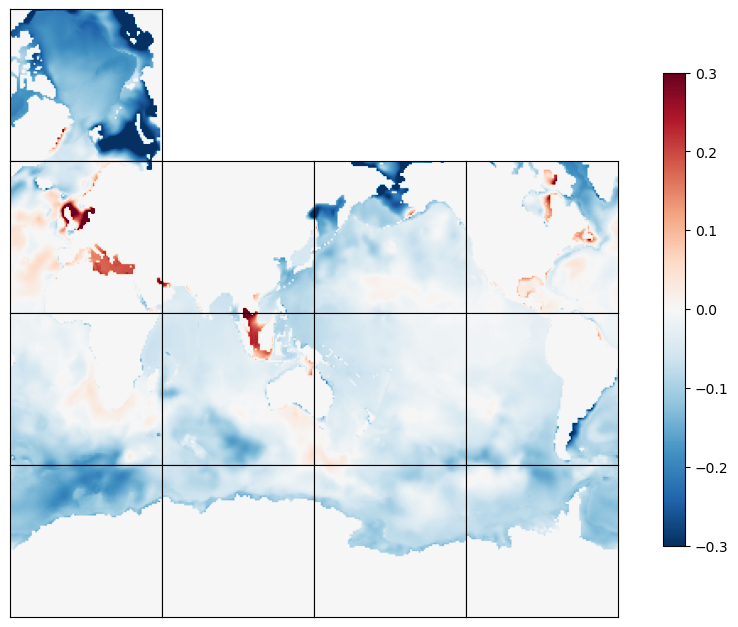

In [181]:
tmpA = ecco.read_llc_to_tiles(new_mds_var_dir, x[0][0], filetype=file_dtype)
ecco.plot_tiles(tmpA, show_colorbar=True, rotate_to_latlon='true', layout='latlon', show_tile_labels=False,cmax=0.3, cmin=-.3);

load_binary_array: loading file /tmp/OBPGMAPA_day_snap/OBPGMAPA_day_snap.0000245412.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


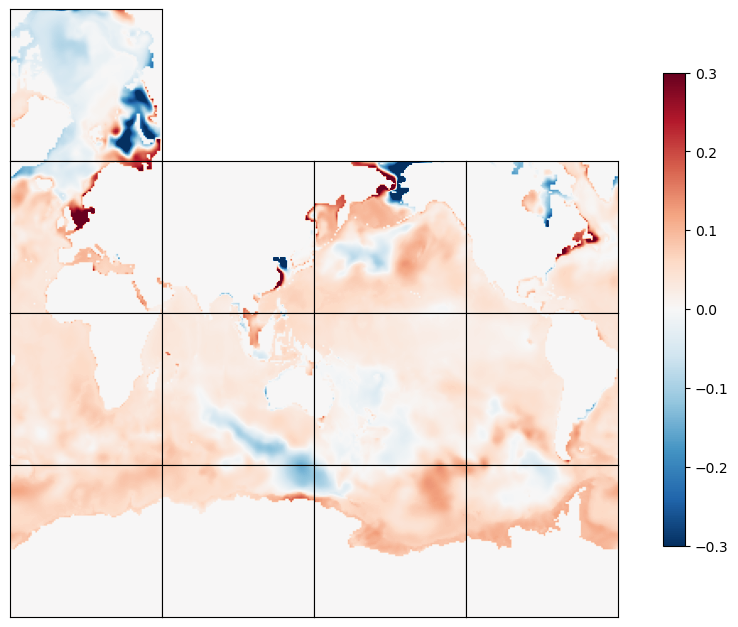

In [182]:
tmpB = ecco.read_llc_to_tiles(new_mds_var_dir, x[0][-1], filetype=file_dtype);
ecco.plot_tiles(tmpB, show_colorbar=True, rotate_to_latlon='true', layout='latlon', show_tile_labels=False, cmax=0.3, cmin=-.3);

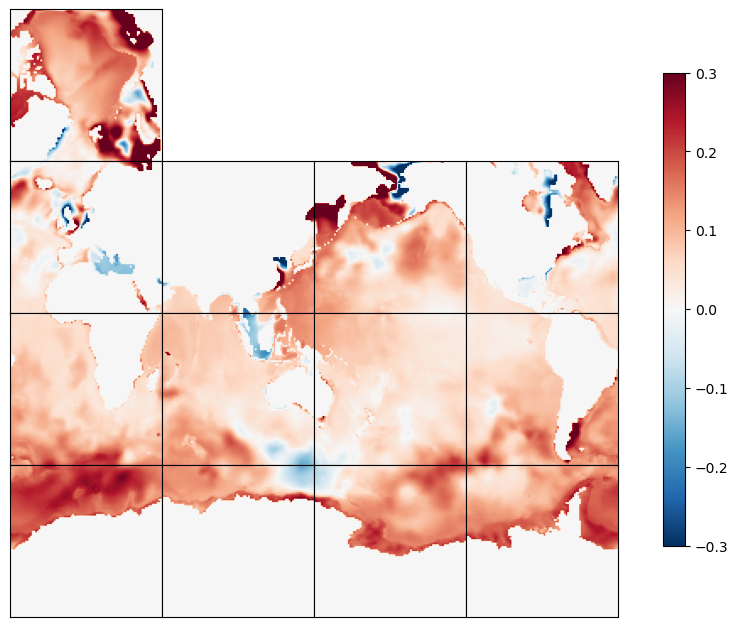

In [183]:
ecco.plot_tiles(tmpB-tmpA, show_colorbar=True, rotate_to_latlon='true', layout='latlon', show_tile_labels=False, cmax=0.3, cmin=-.3);